In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

import figurefirst as fifi
import scipy.fftpack

import pynumdiff

# Raw data

In [130]:
pynumdiff.utils.simulate.lorenz_x?

In [135]:
timeseries_length = 4
r = pynumdiff.utils.simulate.lorenz_x(timeseries_length, noise_parameters=[0, 0.2])

In [136]:
x, x_truth, dxdt_truth, _ = r

In [137]:
t = np.linspace(0, timeseries_length, len(x))

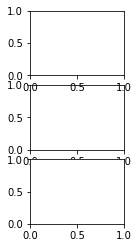

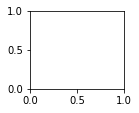

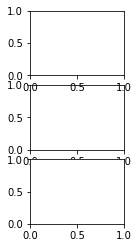

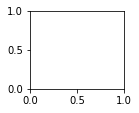

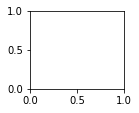

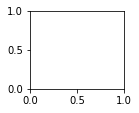

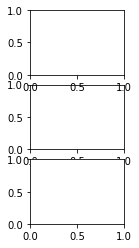

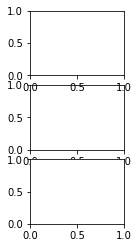

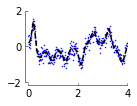

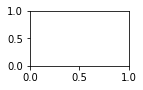

In [138]:
layout = fifi.svg_to_axes.FigureLayout('wind_speed.svg', autogenlayers=True, 
                                           make_mplfigures=True, hide_layers=[])

ax = layout.axes[('raw', 'wind_speed')]

ax.plot(t, x, '.', color='blue', markersize=1)
ax.plot(t, x_truth, '--', color='black', markersize=1)
ax.set_xlim(0, 4)
ax.set_ylim(-2,2)
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 tick_length=2.5,
                                 yticks = [-2, 0, 2],
                                 spine_locations={'left': 3, 'bottom': 3},
                                 linewidth=0.5)

In [139]:
fifi.mpl_functions.set_fontsize(ax, 6)
    
layout.append_figure_to_layer(layout.figures['raw'], 'raw', cleartarget=True)
layout.write_svg('wind_speed.svg')

# Power spectra
keep 20% of the power in this case

In [140]:
wind_speed = x

In [141]:
yf = scipy.fftpack.fft(wind_speed)
N = len(t)
dt = np.mean(np.diff(t))
xf = np.linspace(0.0, 1.0/(2.0*dt), N/2)

/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


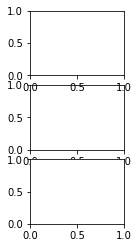

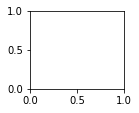

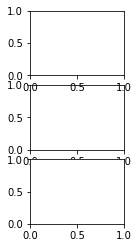

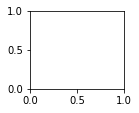

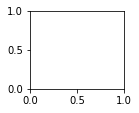

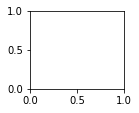

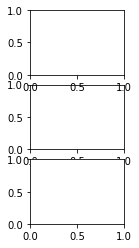

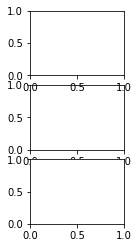

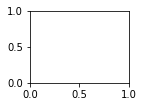

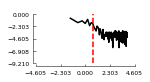

In [142]:
layout = fifi.svg_to_axes.FigureLayout('wind_speed.svg', autogenlayers=True, 
                                           make_mplfigures=True, hide_layers=[])
ax = layout.axes[('spectra', 'spectra')]

P = np.log(2.0/N * np.abs(yf[:N//2]))
ax.plot(np.log(xf), P, color='black', zorder=-10)
#ax.vlines(np.log(0.005), np.log(1e-4), np.log(1), linestyle='--', color='red')
ax.vlines(np.log(2), np.log(1e-4), np.log(1), linestyle='--', color='red')

frequencies = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2])
power = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0])

ax.set_ylim(1e-4, 1)

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 xticks=np.log(frequencies),
                                 yticks=np.log(power),
                                 tick_length=2.5,
                                 spine_locations={'left': 3, 'bottom': 3},
                                 linewidth=0.5)

#ax.set_xticklabels([])
#ax.set_yticklabels([])

fifi.mpl_functions.set_fontsize(ax, 6)
    
layout.append_figure_to_layer(layout.figures['spectra'], 'spectra', cleartarget=True)
layout.write_svg('wind_speed.svg')

# choose gamma based on frequency

In [143]:
frequency = 2# 0.005

In [144]:
dt

0.010025062656641603

In [145]:
def plot_method(method_name, method_parent, method, wind_speed, frequency, dt):
    
    if method_name == 'savgol':
        gamma_errcorr = np.exp(0.303*np.log(frequency) + 0.61*np.log(dt) - 2.41)
        gamma_rmse = np.exp(-1.1*np.log(frequency) -0.9*np.log(dt) - 5.3)
        spines = ['left']
    elif method_name == 'tvrj':
        gamma_errcorr = np.exp(0.33*np.log(frequency) + 1.13*np.log(dt) - 0.44)
        gamma_rmse = np.exp(-1.23*np.log(frequency) -0.43*np.log(dt) -1.81)
        spines = []
    elif method_name == 'butter':
        gamma_errcorr = np.exp(0.14*np.log(frequency) + 1.11*np.log(dt) - 0.82)
        gamma_rmse = np.exp(-0.88*np.log(frequency) + 0.26*np.log(dt) - 0.59)
        spines = []
    elif method_name == 'kalman':
        gamma_errcorr = np.exp(0.07*np.log(frequency) + 0.46*np.log(dt) - 8.01)
        gamma_rmse = np.exp(-1.12*np.log(frequency) -0.97*np.log(dt) - 6.47)
        spines = []
    
    
    gamma_general = gamma_rmse/5.
    #gamma_general = np.mean([(gamma_rmse), (gamma_errcorr)])
        
    
    
    print('______________________________________________________')
    print(method_name)
    print('gamma_rmse: ', gamma_rmse)
    print('gamma_errcorr: ', gamma_errcorr)
    print('gamma_general: ', gamma_general)


    layout = fifi.svg_to_axes.FigureLayout('wind_speed.svg', autogenlayers=True, 
                                               make_mplfigures=True, hide_layers=[])
    
    ylim = [-15,15]
    xlim = [0,4]
    
    
    ## model discovery
    ax = layout.axes[(method_name, 'model_discovery')]
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma_errcorr)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](wind_speed, dt, params)

    ax.plot(t, xdot_smooth, color='red')
    ax.plot(t, dxdt_truth, '--', color='black')
    ax.set_ylim(ylim[0], ylim[-1])
    ax.set_xlim(xlim[0], xlim[-1])
    fifi.mpl_functions.adjust_spines(ax, spines, 
                                     tick_length=2.5,
                                     #yticks=[-0.2, 0, 0.2, 0.4],
                                     #xticks=[0,20,40,60,80,100],
                                     spine_locations={'left': 3, 'bottom': 3},
                                     linewidth=0.5)
    print('___________model discovery_____________________')
    rmse = np.sqrt(np.mean((xdot_smooth - dxdt_truth)**2))
    errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth, dxdt_truth)
    print('error correlation: ', errcorr)
    print('rmse: ', rmse)
    
    
    ## general
    ax = layout.axes[(method_name, 'general')]
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma_general)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](wind_speed, dt, params)

    ax.plot(t, xdot_smooth, color='red')
    ax.plot(t, dxdt_truth, '--', color='black')
    ax.set_ylim(ylim[0], ylim[-1])
    ax.set_xlim(xlim[0], xlim[-1])
    fifi.mpl_functions.adjust_spines(ax, spines, 
                                     tick_length=2.5,
                                     #yticks=[-0.2, 0, 0.2, 0.4],
                                     #xticks=[0,20,40,60,80,100],
                                     spine_locations={'left': 3, 'bottom': 3},
                                     linewidth=0.5)
    
    print('___________________general_____________________')
    rmse = np.sqrt(np.mean((xdot_smooth - dxdt_truth)**2))
    errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth, dxdt_truth)
    print('error correlation: ', errcorr)
    print('rmse: ', rmse)
    
    
    
    
    ## control
    ax = layout.axes[(method_name, 'control')]
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma_rmse)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](wind_speed, dt, params)

    ax.plot(t, xdot_smooth, color='red')
    ax.plot(t, dxdt_truth, '--', color='black')
    ax.set_ylim(ylim[0], ylim[-1])
    ax.set_xlim(xlim[0], xlim[-1])
    spines.append('bottom')
    fifi.mpl_functions.adjust_spines(ax, spines, 
                                     tick_length=2.5,
                                     #yticks=[-0.2, 0, 0.2, 0.4],
                                     #xticks=[0,20,40,60,80,100],
                                     spine_locations={'left': 3, 'bottom': 3},
                                     linewidth=0.5)
    
    print('___________________control_____________________')
    rmse = np.sqrt(np.mean((xdot_smooth - dxdt_truth)**2))
    errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth, dxdt_truth)
    print('error correlation: ', errcorr)
    print('rmse: ', rmse)
    
    
    

    fifi.mpl_functions.set_fontsize(ax, 6)
    layout.append_figure_to_layer(layout.figures[method_name], method_name, cleartarget=True)
    layout.write_svg('wind_speed.svg')
    
    
    

______________________________________________________
savgol
gamma_rmse:  0.14659793898071857
gamma_errcorr:  0.006686910579360924
gamma_general:  0.029319587796143715


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

___________model discovery_____________________
error correlation:  0.0027185333127834467
rmse:  3.641425738712364


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


___________________general_____________________
error correlation:  0.029443484891525377
rmse:  1.8872122780279321
___________________control_____________________
error correlation:  0.5191581213290097
rmse:  1.5175217227261302


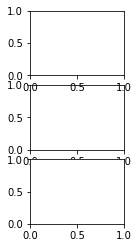

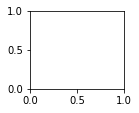

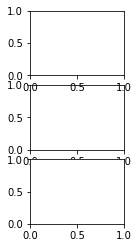

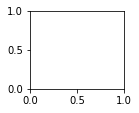

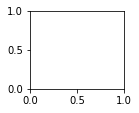

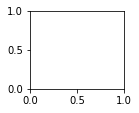

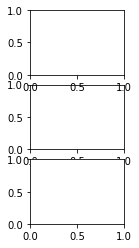

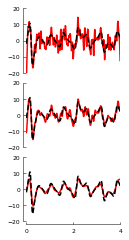

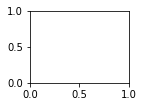

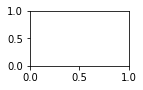

In [146]:
method_name = 'savgol'
method_parent = 'linear_model'
method = 'savgoldiff'
plot_method(method_name, method_parent, method, wind_speed, frequency, dt)

______________________________________________________
tvrj
gamma_rmse:  0.5048852021076151
gamma_errcorr:  0.004461477885241554
gamma_general:  0.10097704042152303
___________model discovery_____________________
error correlation:  2.674544124324711e-07
rmse:  7.600504276532263
___________________general_____________________
error correlation:  0.0666848736955285
rmse:  1.532053657219479
___________________control_____________________
error correlation:  0.363465247692934
rmse:  2.4389889586872173


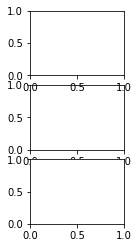

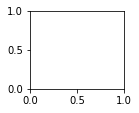

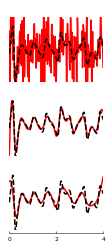

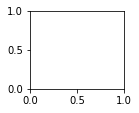

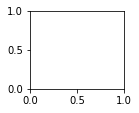

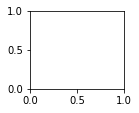

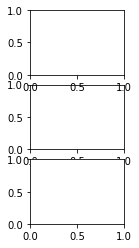

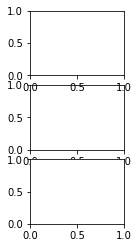

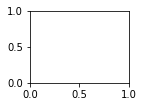

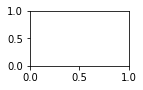

In [147]:
method_name = 'tvrj'
method_parent = 'total_variation_regularization'
method = 'jerk_sliding'
plot_method(method_name, method_parent, method, wind_speed, frequency, dt)

______________________________________________________
butter
gamma_rmse:  0.09102118900208934
gamma_errcorr:  0.0029324417928290824
gamma_general:  0.01820423780041787


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

___________model discovery_____________________
error correlation:  1.0913391096620404e-06
rmse:  10.40040125546126


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


___________________general_____________________
error correlation:  0.0004565623920969769
rmse:  2.404126665548335
___________________control_____________________
error correlation:  0.14620256452244978
rmse:  1.1953561055272286


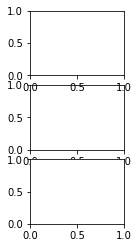

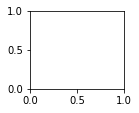

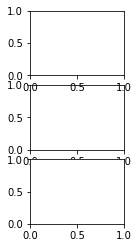

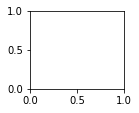

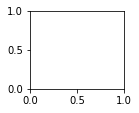

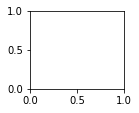

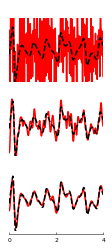

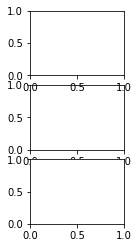

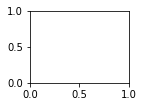

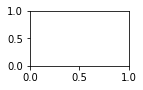

In [148]:
method_name = 'butter'
method_parent = 'smooth_finite_difference'
method = 'butterdiff'
plot_method(method_name, method_parent, method, wind_speed, frequency, dt)

______________________________________________________
kalman
gamma_rmse:  0.06193079059735115
gamma_errcorr:  4.196366039008116e-05
gamma_general:  0.01238615811947023
___________model discovery_____________________
error correlation:  1.365385555864038e-06
rmse:  64.08657668824401
___________________general_____________________
error correlation:  1.676331010226553e-05
rmse:  6.365699914812345
___________________control_____________________
error correlation:  0.07183905522671644
rmse:  2.065039876617532


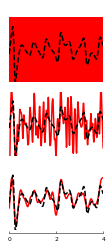

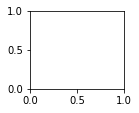

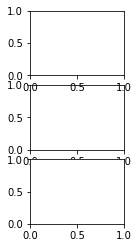

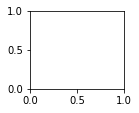

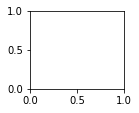

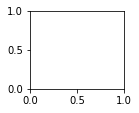

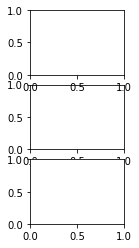

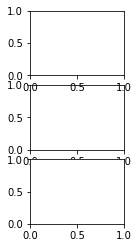

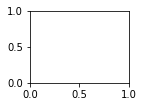

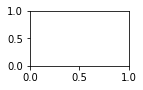

In [117]:
method_name = 'kalman'
method_parent = 'kalman_smooth'
method = 'constant_acceleration'
plot_method(method_name, method_parent, method, wind_speed, frequency, dt)

In [151]:
def pareto_plot(method_name, method_parent, method, wind_speed, frequency, dt):
    
    if method_name == 'savgol':
        gamma_errcorr = np.exp(0.303*np.log(frequency) + 0.61*np.log(dt) - 2.41)
        gamma_rmse = np.exp(-1.1*np.log(frequency) -0.9*np.log(dt) - 5.3)
        spines = ['left']
    elif method_name == 'tvrj':
        gamma_errcorr = np.exp(0.33*np.log(frequency) + 1.13*np.log(dt) - 0.44)
        gamma_rmse = np.exp(-1.23*np.log(frequency) -0.43*np.log(dt) -1.81)
        spines = []
    elif method_name == 'butter':
        gamma_errcorr = np.exp(0.14*np.log(frequency) + 1.11*np.log(dt) - 0.82)
        gamma_rmse = np.exp(-0.88*np.log(frequency) + 0.26*np.log(dt) - 0.59)
        spines = []
    elif method_name == 'kalman':
        gamma_errcorr = np.exp(0.07*np.log(frequency) + 0.46*np.log(dt) - 8.01)
        gamma_rmse = np.exp(-1.12*np.log(frequency) -0.97*np.log(dt) - 6.47)
        spines = []
    
    #if method_name == 'tvrj':
    #    print(gamma_errcorr, gamma_rmse)
    #    gammas = np.linspace(gamma_errcorr, gamma_rmse/2, 10)
    #else:
    gammas = np.linspace(gamma_errcorr, gamma_rmse, 20)
    errcorrs = []
    rmses = []
    
    
    ## model discovery
    for gamma in gammas:
        params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma)
        x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](wind_speed, dt, params)

        rmse = np.sqrt(np.mean((xdot_smooth - dxdt_truth)**2))
        errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth, dxdt_truth)
        rmses.append(rmse)
        errcorrs.append(errcorr)
        
    layout = fifi.svg_to_axes.FigureLayout('wind_speed.svg', autogenlayers=True, 
                                               make_mplfigures=True, hide_layers=[])
    
    ax = layout.axes[(method_name+'_pareto', 'pareto')]
    ax.plot(np.log(rmses), errcorrs)
    ax.plot(np.log(rmses), errcorrs, '.')
    ax.plot(np.log(rmses[int(len(gammas)/4)]), errcorrs[int(len(gammas)/4)], '*')
    ax.set_xlim(0.1, 2.5)
    ax.set_ylim(0,1)
    
    fifi.mpl_functions.set_fontsize(ax, 6)
    layout.append_figure_to_layer(layout.figures[method_name+'_pareto'], method_name+'_pareto', cleartarget=True)
    layout.write_svg('wind_speed.svg')
    
    
    
    
    return gammas, errcorrs, rmses

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

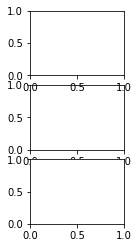

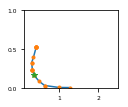

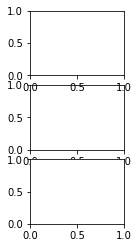

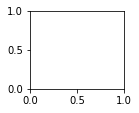

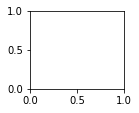

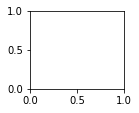

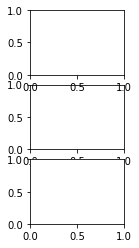

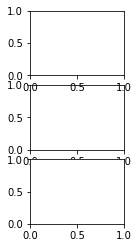

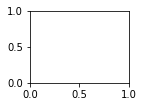

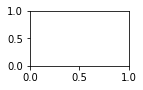

In [152]:
method_name = 'savgol'
method_parent = 'linear_model'
method = 'savgoldiff'
gammas, errcorrs, rmses = pareto_plot(method_name, method_parent, method, wind_speed, frequency, dt)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

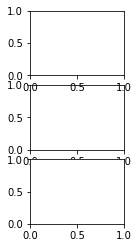

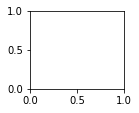

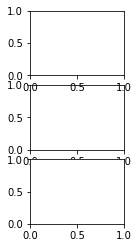

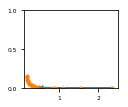

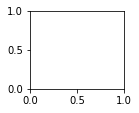

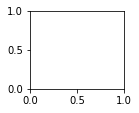

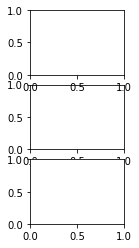

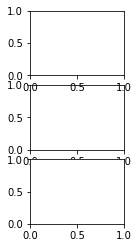

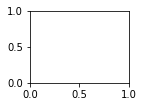

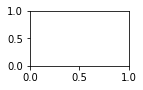

In [153]:
method_name = 'butter'
method_parent = 'smooth_finite_difference'
method = 'butterdiff'
gammas, errcorrs, rmses = pareto_plot(method_name, method_parent, method, wind_speed, frequency, dt)

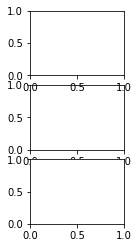

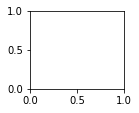

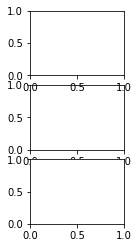

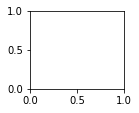

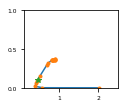

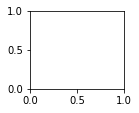

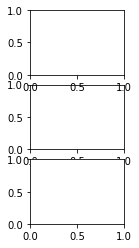

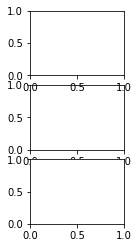

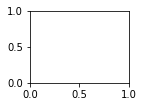

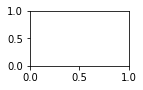

In [154]:
method_name = 'tvrj'
method_parent = 'total_variation_regularization'
method = 'jerk'
gammas, errcorrs, rmses = pareto_plot(method_name, method_parent, method, wind_speed, frequency, dt)

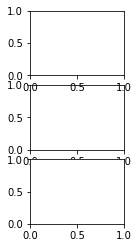

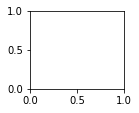

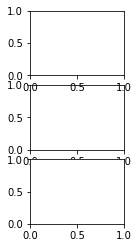

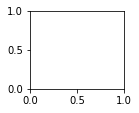

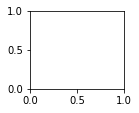

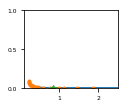

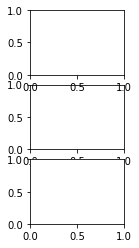

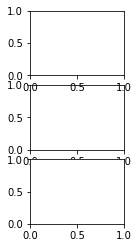

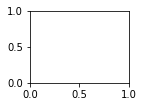

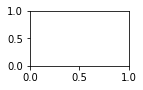

In [155]:
method_name = 'kalman'
method_parent = 'kalman_smooth'
method = 'constant_acceleration'
gammas, errcorrs, rmses = pareto_plot(method_name, method_parent, method, wind_speed, frequency, dt)